# Using the default resnet

## Imports

In [27]:
import pandas as pd
from enum import Enum
import torch
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,Subset
from torchvision.models import resnet18,resnet50
from torcheval.metrics import BinaryAccuracy

## Parameters

In [28]:
class class_mode(Enum):
    S_or_Z = 0
    S_or_Z_or_O = 1


USE_GPU = True
CATALOG_PATH = '../Data/subset_gz1_desi_cross_cat.csv'
DATA_PATH = '../Data/Subset'
MODE = class_mode.S_or_Z_or_O

In [29]:
#Run processes on CPU or GPU
if USE_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.1 GB
Cached:    3.1 GB
Using device: cuda


## Importing data

In [30]:
catalog = pd.read_csv(CATALOG_PATH)

if MODE == class_mode.S_or_Z:

    #Select only S or Z 
    catalog = catalog[catalog['P_EL']<0.8]
    #Select features (clockwise and anti-clockwise probabilities)
    Y = catalog[['P_CW','P_ACW']]
    classes = [r'P_CW',r'P_ACW']
    num_classes = 2

elif MODE == class_mode.S_or_Z_or_O:
    #Select only S or Z or other
    catalog['P_OTHER'] = catalog['P_EL']+catalog['P_EDGE']+catalog['P_DK']+catalog['P_MG']
    Y = catalog[['P_CW','P_ACW','P_OTHER']]
    classes = ['P_CW','P_ACW','P_OTHER']
    num_classes = 3

print(f"Loaded {catalog.shape[0]} galaxy images")
print(Y.head(10))

Loaded 1500 galaxy images
    P_CW  P_ACW  P_OTHER
0  0.818  0.000    0.182
1  0.968  0.032    0.000
2  1.000  0.000    0.000
3  1.000  0.000    0.000
4  0.862  0.034    0.103
5  0.909  0.000    0.090
6  0.929  0.000    0.072
7  0.926  0.000    0.074
8  0.833  0.062    0.104
9  0.970  0.030    0.000


### Generate list of file locations from catalog

In [31]:
def get_file_paths(catalog_to_convert,folder_path ):
    brick_ids = catalog_to_convert['dr8_id'].str.split("_",expand=True)[0]
    dr8_ids = catalog_to_convert['dr8_id']
    file_locations = folder_path+'/'+brick_ids+'/'+dr8_ids+'.jpg'
    return file_locations

file_locations = get_file_paths(catalog,DATA_PATH)

### Image processing functions

In [32]:
COLOR = True
RAW_SIZE = 15
IMG_SIZE = 160

TARGET_SIZE = 5
TRANSLATE = 0.
ROTATE = False
FLIP = False
LABEL = 2
SHUFFLE = False


def img_proc(img, raw_size=RAW_SIZE, target_size=TARGET_SIZE, translate=TRANSLATE, rotate=ROTATE,
             random_generator=None):
    assert img.shape[-2] == img.shape[-1]
    assert translate >= 0
    
    if random_generator is None:
        random_generator = int.from_bytes(os.urandom(4), byteorder='little')
    rng = np.random.default_rng(random_generator)

    if not isinstance(target_size, (float, int)):
        target_size = rng.uniform(*target_size)
    if rotate:
        assert target_size * (1 + translate) * 2**0.5 < raw_size
        if isinstance(rotate, bool):
            rotate = rng.uniform(0., 360.)
        img = ndimage.rotate(img, rotate, axes=(-1, -2), reshape=False, order=1)
    else:
        assert target_size * (1 + translate) < raw_size
    s = img.shape[-1]
    translate = translate * target_size
    t_x = rng.uniform(-translate, translate) if translate > 0 else 0
    t_y = rng.uniform(-translate, translate) if translate > 0 else 0
    a = int(s * (raw_size - target_size + t_x) / (2 * raw_size))
    b = int(s * (raw_size - target_size + t_y) / (2 * raw_size))
    c = int(s * target_size / raw_size)
    return img[..., a:(a + c), b:(b + c)]


def read_img(path, color=COLOR, img_size=IMG_SIZE, atleast_3d=True, random_flip=FLIP,
             shuffle_channel=SHUFFLE, random_generator=None, **kwargs):
    if random_generator is None:
        random_generator = int.from_bytes(os.urandom(4), byteorder='little')
    rng = np.random.default_rng(random_generator)

    jpeg_file = (np.asarray(Image.open(path)) / 255).astype(np.float32)
    if color:
        img = np.moveaxis(jpeg_file, -1, 0)
        if shuffle_channel:
            if isinstance(shuffle_channel, bool):
                shuffle_channel = rng.permutation(img.shape[0])
            img = img[shuffle_channel]
    else:
        img = np.mean(jpeg_file, axis=-1)
    img = img_proc(img, random_generator=rng, **kwargs)
    rng.uniform(size=100) # just to jump the rng

    if img_size is not None:
        z = img_size / img.shape[-1]
        if img.ndim == 2:
            img = ndimage.zoom(img, (z, z), order=1)
            if atleast_3d:
                img = img[np.newaxis]
        elif img.ndim == 3:
            img = ndimage.zoom(img, (1, z, z), order=1)
        else:
            raise RuntimeError

    if random_flip:
        flip = int(rng.integers(0, 2, 1))
        flip = 2 * flip - 1
    else:
        flip = 1
    return np.ascontiguousarray(img[..., ::flip])

### Reading in images

In [33]:
#Takes about a minute
X = torch.empty(0, 3, 160,160)
for i in range(len(file_locations)):
    X = torch.cat((X, torch.from_numpy(read_img(file_locations[i])).float()[np.newaxis]), 0)

In [34]:
Y = torch.from_numpy(Y.values).float()
# if MODE == class_mode.S_or_Z:
#Y = Y.softmax(dim=1)
#print(Y[0:5])

print(f"Processed {X.shape[0]} images")

Processed 1500 images


## Setting up model

### Hyperparameters

In [46]:
learning_rate = 0.0001
weight_decay = 1

num_epochs = 120
batch_size = 60 #60

modfile = 'resnet18_modfile.pt'

### Training model function

In [47]:
def train(model, trainloader, loss_criterion,optimiser, device):
    train_loss = 0.0
    num_batches = len(trainloader)
    model.train()

    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        #Calculate train loss
        p_y = model(data)
        loss = loss_criterion(p_y, labels)
        
        train_loss += loss.item() #* data.size(0)
        
        #Feed the loss back
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

    train_loss /= num_batches
    return train_loss

### Validating model function

In [37]:
def accuracy(predicted_labels,true_labels):
    #Takes in softmaxed labels, checks if max column is the same

    true_highest_prob = torch.argmax(true_labels, dim=1)
    predicted_highest_prob = torch.argmax(predicted_labels, dim=1)
    #print(predicted_highest_prob)
    #print(true_highest_prob)    
    
    metric = BinaryAccuracy()
    metric.update(predicted_highest_prob,true_highest_prob)
    test_accuracy = metric.compute()
    #print(test_accuracy.float())
    return test_accuracy

In [ ]:
def test(model, testloader,loss_criterion, device):
    test_loss = 0.0
    test_accuracy = 0.0
    size = len(testloader.dataset)
    num_batches = len(testloader)
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            #Softmax output and labels for passing to cross-entropy function
            p_y = model(data)
            print(p_y.softmax(dim=1)[0:5])
            #print(p_y[0:5])
            #Calculate test loss         
            loss = loss_criterion(p_y, labels)
            test_loss += loss.item() * data.size(0)
            test_accuracy += accuracy(p_y.softmax(dim=1),labels).type(torch.float)* data.size(0)

    test_loss /= size
    test_accuracy /= size
        
    return test_loss, test_accuracy

### Split data into train and test

In [39]:
def data_split(frac_val, data):
    dataset_size = len(data)
    nval = int(frac_val*dataset_size)

    indices = list(range(dataset_size))
    train_indices, val_indices = indices[nval:], indices[:nval]

    train_sampler = Subset(data, train_indices)
    valid_sampler = Subset(data, val_indices)

    train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(valid_sampler, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

## Running model

In [48]:
#function to run the entire model train/test loop
early_stopping = True
QUIET = False

def test_train_model(X,Y,model):
    X_tensor = X
    Y_tensor = Y #torch.from_numpy(Y.values).float()

    dataset = TensorDataset(X_tensor, Y_tensor)
    train_loader,test_loader = data_split(0.7,dataset)

    #optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)#0.005, #0.01
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)
    loss_criterion = nn.CrossEntropyLoss()
    #array to store metrics
    result_arr = np.zeros((num_epochs,4))

    _bestloss = 1.
    best_epoch = 0
    
    #NN learning
    for epoch in range(num_epochs):
    
        train_loss = train(model, train_loader, loss_criterion, optimizer, device)
        val_loss, test_accuracy = test(model, test_loader,loss_criterion, device)
        
        #scheduler.step() 

        if early_stopping and val_loss<_bestloss:
            _bestloss = val_loss
            torch.save(model.state_dict(), modfile)
            best_epoch = epoch

        #set output row
        results = [epoch, train_loss, val_loss,test_accuracy]
        result_arr[epoch] = results

        #print epoch results
        if not QUIET:
            print(f"Epoch: {epoch}, Train Loss: {train_loss:4f}, Validation Loss: {val_loss:4f}, Accuracy: {test_accuracy:4f}, Learning Rate: {optimizer.param_groups[0]['lr']:4f}")
    
    if not early_stopping:
        torch.save(model.state_dict(), modfile)
        best_epoch = -1

    return result_arr, best_epoch

## Jia et al Model

In [41]:
from typing import Type, Any, Callable, Union, List, Optional, Tuple
from torch import Tensor

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_channels: int = 3,
        num_classes: int = 1000,
        use_max_pool: bool = False,
        use_avg_pool: bool = True,
        avg_pool_size: Tuple[int] = (4, 4),
        add_fc: Optional[List[int]] = None,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(num_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d(avg_pool_size)
        pool_expansion = 1
        if not use_avg_pool:
            pool_expansion = 16 if use_max_pool else 64
        else:
            pool_expansion = np.prod(avg_pool_size)
        self.fc = self._make_fc(512 * block.expansion * pool_expansion, num_classes, add_fc)

        self.use_max_pool = use_max_pool
        self.use_avg_pool = use_avg_pool

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    @staticmethod
    def _make_fc(in_features: int, out_features: int, add_fc: Optional[List[int]]):
        if add_fc is None:
            return nn.Linear(in_features, out_features)
        else:
            add_fc.insert(0, in_features)
            add_fc.append(out_features)
            fc_layers = []
            for i in range(len(add_fc) - 1):
                fc_layers.append(nn.Linear(add_fc[i], add_fc[i + 1]))
                if i != len(add_fc) - 2:
                    fc_layers.append(nn.Tanh())
            return nn.Sequential(*fc_layers)

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.use_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.use_avg_pool:
            x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    def predict(self, x: Tensor) -> Tensor:
        x_i = torch.flip(x, (-1,))
        a = self(x)
        a_i = self(x_i)
        return torch.cat((a[..., 0:1], a_i[..., 0:1], 0.5 * (a[..., 1:2] + a_i[..., 1:2])), dim=-1)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        raise NotImplementedError
        """state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)"""
    return model


def resnet18_Jia(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

def resnet50_Jia(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)                  

## Actually run model

In [52]:
#selected_model = resnet18(num_classes=num_classes)
selected_model = resnet50_Jia(num_channels=3, num_classes=num_classes, use_max_pool=True, use_avg_pool=True,
                           avg_pool_size=(1, 1), add_fc=[512, 512, 64, 64])

if torch.cuda.is_available():
    selected_model.cuda()

result_arr1, best_epoch = test_train_model(X,Y,selected_model)

tensor([[-0.5555, -0.4554,  0.7577],
        [-0.5545, -0.4562,  0.7549],
        [-0.5563, -0.4546,  0.7552],
        [-0.5572, -0.4550,  0.7583],
        [-0.5562, -0.4555,  0.7573]], device='cuda:0')
tensor([[-0.5561, -0.4551,  0.7573],
        [-0.5569, -0.4563,  0.7563],
        [-0.5550, -0.4556,  0.7563],
        [-0.5545, -0.4556,  0.7552],
        [-0.5562, -0.4544,  0.7566]], device='cuda:0')
tensor([[-0.5557, -0.4537,  0.7548],
        [-0.5545, -0.4575,  0.7565],
        [-0.5591, -0.4531,  0.7543],
        [-0.5544, -0.4554,  0.7556],
        [-0.5557, -0.4543,  0.7562]], device='cuda:0')
tensor([[-0.5543, -0.4560,  0.7544],
        [-0.5624, -0.4525,  0.7559],
        [-0.5559, -0.4548,  0.7567],
        [-0.5570, -0.4540,  0.7544],
        [-0.5560, -0.4551,  0.7556]], device='cuda:0')
tensor([[-0.5570, -0.4539,  0.7591],
        [-0.5571, -0.4548,  0.7563],
        [-0.5574, -0.4549,  0.7549],
        [-0.5547, -0.4550,  0.7549],
        [-0.5546, -0.4556,  0.7558]], de

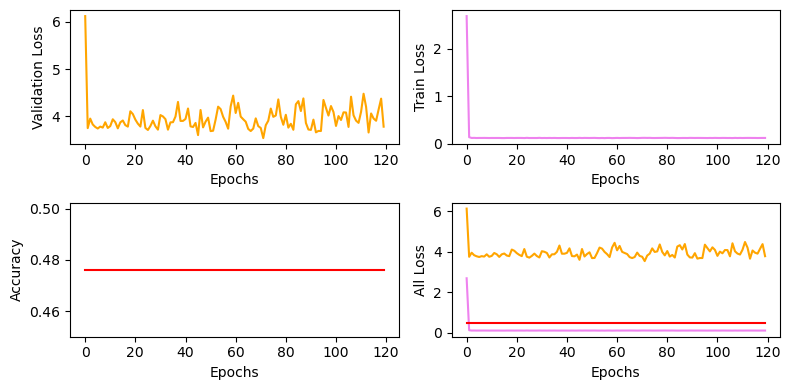

In [43]:
#plot the training cycle
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(221) 
#plt.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', label='Accuracy')
ax1.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss')

ax2 = fig.add_subplot(222) 
ax2.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Train Loss')

ax3 = fig.add_subplot(223) 
ax3.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', c='red',label='Accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')

ax4 = fig.add_subplot(224) 
ax4.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Validation loss')
ax4.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
ax4.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', c='red',label='Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('All Loss')
#ax4.legend()
plt.tight_layout()
plt.show()

In [44]:
t1 = torch.from_numpy(np.array([[0.9,0.1],[0.2,0.8],[0.7,0.3],[0.9,0.1]]))
t2 = torch.from_numpy(np.array([[1,0],[1,0],[1,0],[1,0]]))

accuracy(t1,t2)

tensor(0.7500)

In [45]:
print(Y[500:505])
print(torch.argmax(Y[500:505], dim=1))

tensor([[0.0380, 0.9230, 0.0380],
        [0.0000, 1.0000, 0.0000],
        [0.0610, 0.8160, 0.1220],
        [0.0000, 0.9620, 0.0380],
        [0.0000, 1.0000, 0.0000]])
tensor([1, 1, 1, 1, 1])
